<a href="https://colab.research.google.com/github/COE70ACapstone/Brain-Segmentation-MRI-Preprocessing/blob/main/3D_MRI_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#downloading necessary files
!wget --header 'Host: fcp-indi.s3.amazonaws.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'http://preprocessed-connectomes-project.org/' --header 'Upgrade-Insecure-Requests: 1' 'https://fcp-indi.s3.amazonaws.com/data/Projects/RocklandSample/NFBS_Dataset.tar.gz' --output-document 'NFBS_Dataset.tar.gz'
!wget --header 'Host: doc-08-2g-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://drive.google.com/' --header 'Cookie: AUTH_9k7m8g8qrj7at7i0b1sl7f8s8gafrr77_nonce=fchj71prkosgs' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-08-2g-docs.googleusercontent.com/docs/securesc/5baff4djp5n2ak1832to2m6lltldb4gl/lld851i2e7pqe774volddlu45niullkl/1621202400000/00677992938550103544/12785117600840412092/1N1Qx-R5tLCX5EhXPoPdyg6YvEkDtf-cD?e=download&authuser=0&nonce=fchj71prkosgs&user=12785117600840412092&hash=0lccq4nigav75jop1timeo66ook4s4q1' --output-document 'ANTs-28-03-2019.7z'
!wget --header 'Host: doc-00-48-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://drive.google.com/' --header 'Cookie: AUTH_9k7m8g8qrj7at7i0b1sl7f8s8gafrr77=12785117600840412092|1621202400000|urd0fgd911j76j00e1g3sfrlmgno1864' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-00-48-docs.googleusercontent.com/docs/securesc/5baff4djp5n2ak1832to2m6lltldb4gl/andn6io8vgl8gpaplbqeg39eum6c4c3k/1621202475000/15988357211529156717/12785117600840412092/1y8N6JpKhyoLDQcscdudwMCgqubjQyfd1?e=download&authuser=0' --output-document 'T1w_MRI_test_data.zip'
!unzip '/content/T1w_MRI_test_data.zip'

# for handling MRI images
!pip install nipype
!pip install antspyx
!pip install nilearn
!pip install SimpleITK

#for segmentation
!pip install --upgrade tensorflow
!pip install tensorflow-keras
!pip install git+https://github.com/qubvel/segmentation_models

# #for running ANTS library in
from google.colab import drive
drive.mount('/gdrive')
!cp '/gdrive/My Drive/ANTs-28-03-2019.7z' ./
!7z x ANTs-28-03-2019.7z
!cp bin/* /usr/local/bin


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 315597527 bytes (301 MiB)

Extracting archive: ANTs-28-03-2019.7z
--
Path = ANTs-28-03-2019.7z
Type = 7z
Physical Size = 315597527
Headers Size = 2380
Method = LZMA2:24 BCJ
Solid = +
Blocks = 1

  0%      0% 1 - bin/ANTS                   1% 1 - bin/ANTS                   1% 2 - bin/ANTSIntegrateVectorField                                       2% 2 - bin/ANTSIntegrateVectorField                                       2% 3 - bin/ANTSIntegrateVelocityField    

In [ ]:
!which antsRegistration

/usr/local/bin/antsRegistration


In [ ]:
#loading ML dependancies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nibabel.testing import data_path
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import nibabel as nib
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import segmentation_models as sm
import tensorflow.python.ops.ragged.ragged_tensor as rt
from segmentation_models.metrics import iou_score
focal_loss = sm.losses.cce_dice_loss
from nipype.interfaces.slicer.filtering.n4itkbiasfieldcorrection import N4ITKBiasFieldCorrection
from nipype import Node, Workflow
from nilearn.image import resample_img
from sklearn.model_selection import train_test_split
import random
import SimpleITK as sitk
from nilearn.image import math_img
from nilearn import image as nii
from nilearn import plotting
from nipype.interfaces.ants import N4BiasFieldCorrection

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Extracting nfbs dataset
import tarfile
file = tarfile.open('/content/NFBS_Dataset.tar.gz')
file.extractall('/content/')
file.close()

In [ ]:
print('Each folder contains..')
print(os.listdir('/content/NFBS_Dataset/A00028185'))

Each folder contains..
['sub-A00028185_ses-NFB3_T1w_brain.nii.gz', 'sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz', 'sub-A00028185_ses-NFB3_T1w.nii.gz']


Each folder contains 3 types of images in nifti format..

T1weighted :This is the raw MRI image with a single channel. Image is 3D and can be imagined as multiple 2D images stacked together.

T1w_brainmask: It is the image mask of the brain or can be called as the ground truth. It is obtained using Beast(Brain extraction based on non local segmentation) method and applying manual edits by domain experts to remove non brain tissue.

T1w_brain:This can be thought of as part of brain stripped from above T1weighted image. This is similar to overlaying mask to actual images.

Objective: Our task here is to build a pipeline that takes in T1 weighted and generates a skull stripped mask.

In [ ]:
img=nib.load('/content/NFBS_Dataset/A00028185/sub-A00028185_ses-NFB3_T1w.nii.gz')
print('Shape of image=',img.shape)

Shape of image= (256, 256, 192)


In [ ]:
#storing the address of 3 types of files
import os
brain_mask=[]
brain=[]
raw=[]
for subdir, dirs, files in os.walk('/content/NFBS_Dataset'):
    for file in files:
        #print os.path.join(subdir, file)y
        filepath = subdir + os.sep + file

        if filepath.endswith(".gz"):
          if '_brainmask.' in filepath:
            brain_mask.append(filepath)
          elif '_brain.' in filepath:
            brain.append(filepath)
          else:
            raw.append(filepath)

In [ ]:
#creating a dataframe for ease of use..
data=pd.DataFrame({'brain_mask':brain_mask,'brain':brain,'raw':raw})
data.head()

,brain_mask,brain,raw
0,/content/NFBS_Dataset/A00061709/sub-A00061709_...,/content/NFBS_Dataset/A00061709/sub-A00061709_...,/content/NFBS_Dataset/A00061709/sub-A00061709_...
1,/content/NFBS_Dataset/A00059845/sub-A00059845_...,/content/NFBS_Dataset/A00059845/sub-A00059845_...,/content/NFBS_Dataset/A00059845/sub-A00059845_...
2,/content/NFBS_Dataset/A00061204/sub-A00061204_...,/content/NFBS_Dataset/A00061204/sub-A00061204_...,/content/NFBS_Dataset/A00061204/sub-A00061204_...
3,/content/NFBS_Dataset/A00053902/sub-A00053902_...,/content/NFBS_Dataset/A00053902/sub-A00053902_...,/content/NFBS_Dataset/A00053902/sub-A00053902_...
4,/content/NFBS_Dataset/A00062248/sub-A00062248_...,/content/NFBS_Dataset/A00062248/sub-A00062248_...,/content/NFBS_Dataset/A00062248/sub-A00062248_...


In [ ]:
# #interactive plot
# img=nii.mean_img('/content/NFBS_Dataset/A00028185/sub-A00028185_ses-NFB3_T1w.nii.gz')
# plotting.view_img(img,bg_img=img)

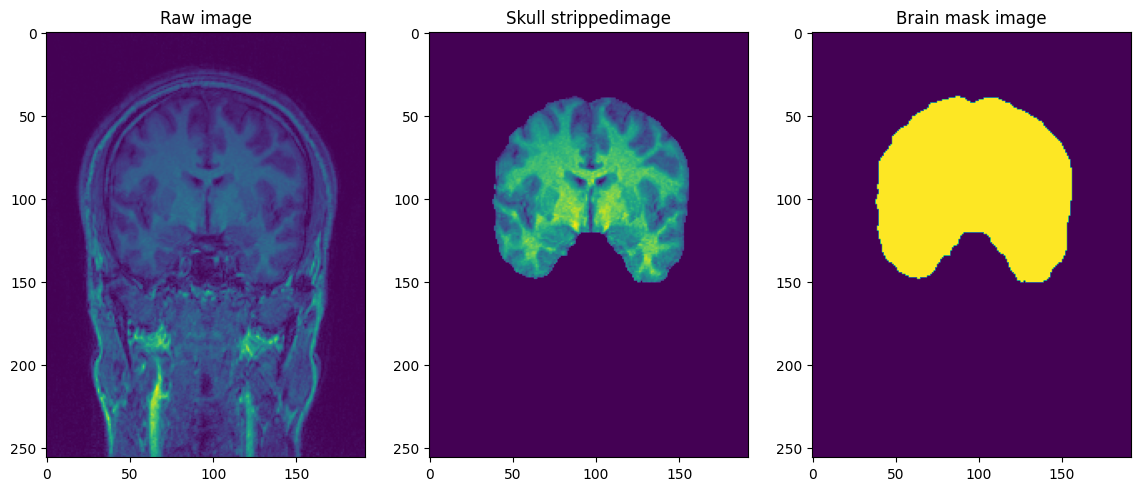

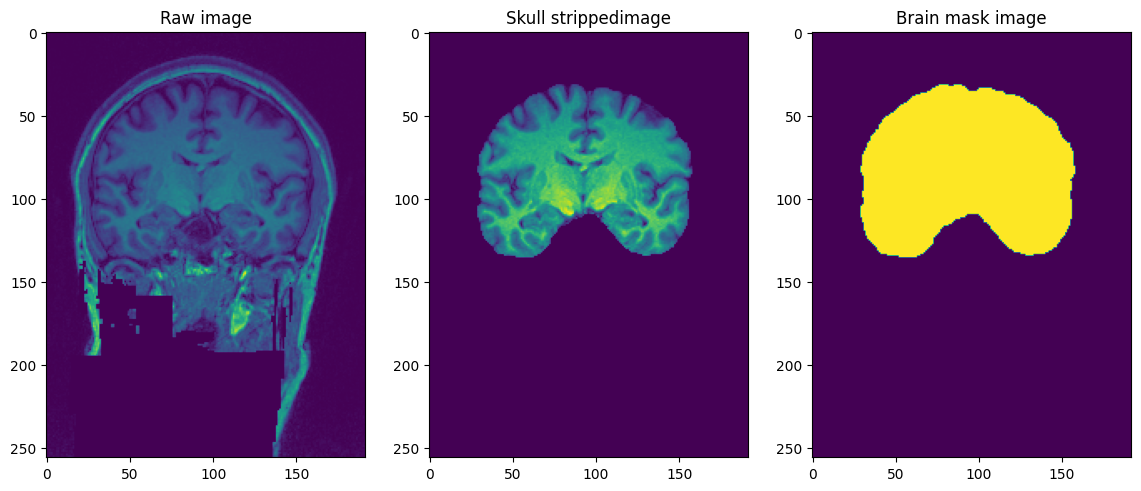

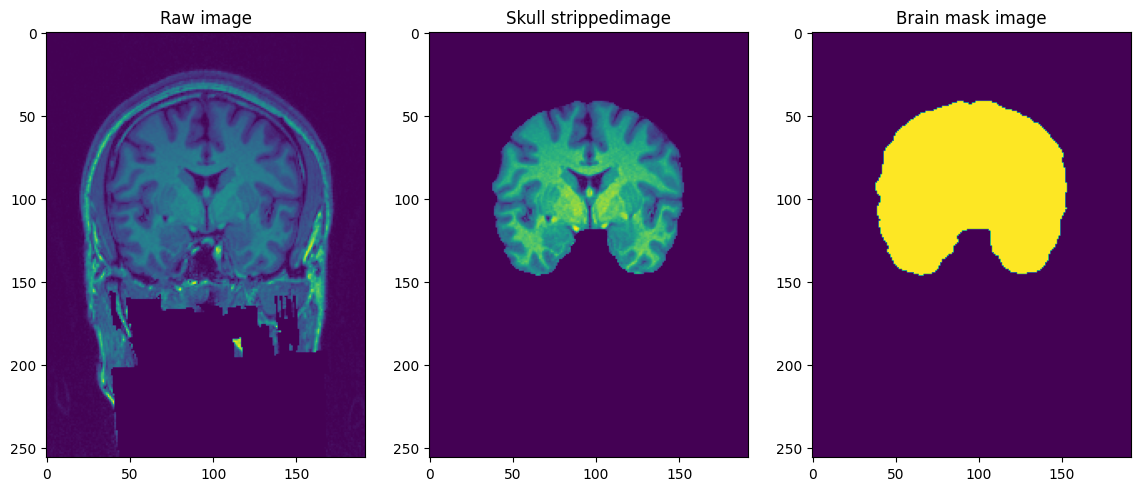

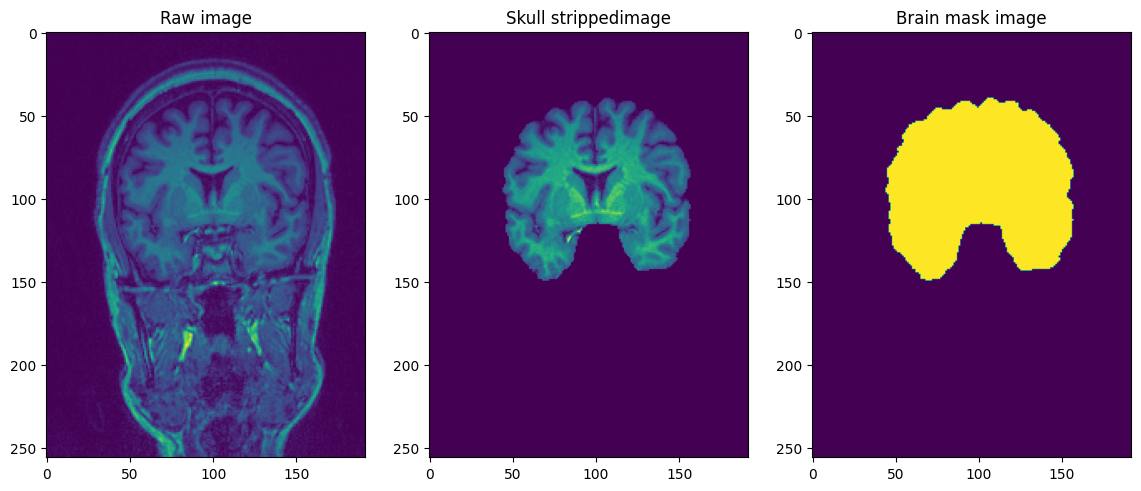

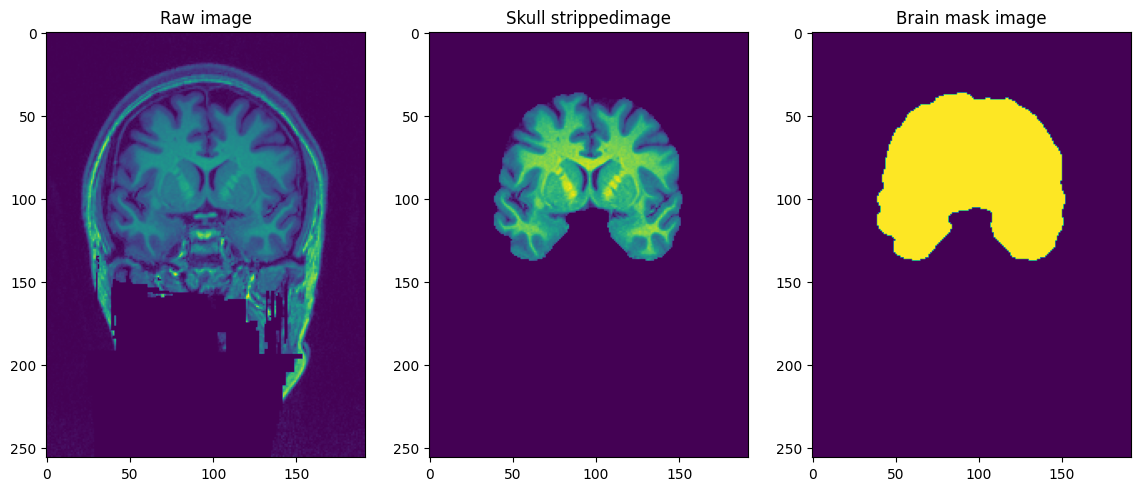

In [ ]:
#lets visualize a couple of examples
for i in range(5):
  fig,ax=plt.subplots(1,3,figsize=(14,10))
  ax[0].set_title('Raw image')
  img = nib.load(data.raw.iloc[i]).get_data()
  ax[0].imshow(img[img.shape[0]//2])
  ax[1].set_title('Skull strippedimage')
  img = nib.load(data.brain.iloc[i]).get_data()
  ax[1].imshow(img[img.shape[0]//2])
  ax[2].set_title('Brain mask image')
  img = nib.load(data.brain_mask.iloc[i]).get_data()
  ax[2].imshow(img[img.shape[0]//2])

#Preprocessing

Downsizing the image due to computational limitations..

In [ ]:
class preprocessing():
  def __init__(self,df):
    self.data=df
    self.raw_index=[]
    self.mask_index=[]
  def bias_correction(self):
    !mkdir bias_correction
    n4 = N4BiasFieldCorrection()
    n4.inputs.dimension = 3
    n4.inputs.shrink_factor = 3
    n4.inputs.n_iterations = [20, 10, 10, 5]
    index_corr=[]
    for i in tqdm(range(len(self.data))):
      n4.inputs.input_image = self.data.raw.iloc[i]
      n4.inputs.output_image ='bias_correction/'+str(i)+'.nii.gz'
      index_corr.append('bias_correction/'+str(i)+'.nii.gz')
      res = n4.run()
    index_corr=['bias_correction/'+str(i)+'.nii.gz' for i in range(125)]
    data['bias_corr']=index_corr
    print('Bias corrected images stored at : bias_correction/')
  def resize_crop(self):
    #Reducing the size of image due to memory constraints
    !mkdir resized
    target_shape = np.array((96,128,160))                   #reducing size of image from 256*256*192 to 96*128*160
    new_resolution = [2,]*3
    new_affine = np.zeros((4,4))
    new_affine[:3,:3] = np.diag(new_resolution)
    # putting point 0,0,0 in the middle of the new volume - this could be refined in the future
    new_affine[:3,3] = target_shape*new_resolution/2.*-1
    new_affine[3,3] = 1.
    raw_index=[]
    mask_index=[]
    #resizing both image and mask and storing in folder
    for i in range(len(data)):
      downsampled_and_cropped_nii = resample_img(self.data.bias_corr.iloc[i], target_affine=new_affine, target_shape=target_shape, interpolation='nearest')
      downsampled_and_cropped_nii.to_filename('resized/raw'+str(i)+'.nii.gz')
      self.raw_index.append('resized/raw'+str(i)+'.nii.gz')
      downsampled_and_cropped_nii = resample_img(self.data.brain_mask.iloc[i], target_affine=new_affine, target_shape=target_shape, interpolation='nearest')
      downsampled_and_cropped_nii.to_filename('resized/mask'+str(i)+'.nii.gz')
      self.mask_index.append('resized/mask'+str(i)+'.nii.gz')
    return self.raw_index,self.mask_index
  def intensity_normalization(self):
    for i in self.raw_index:
      image = sitk.ReadImage(i)
      resacleFilter = sitk.RescaleIntensityImageFilter()
      resacleFilter.SetOutputMaximum(255)
      resacleFilter.SetOutputMinimum(0)
      image = resacleFilter.Execute(image)
      sitk.WriteImage(image,i)
    print('Normalization done. Images stored at: resized/')

In [ ]:
pre=preprocessing(data)
pre.bias_correction()
r_ind,g_ind=pre.resize_crop()
pre.intensity_normalization()

mkdir: cannot create directory ‘bias_correction’: File exists


  1%|          | 1/125 [02:34<5:20:07, 154.90s/it]


KeyboardInterrupt: 

#Model and inference

As architecture here i have used a Unet with 3d convolutions,maxpooling and conv transpose.

In [ ]:
class model():
  def __init__(self,):
    pass
  def split(self,resized_img,resized_mask):
    self.X_train,self.X_test,self.y_train,self.y_test=train_test_split(resized_img,resized_mask,test_size=0.1)
    return self.X_train,self.X_test,self.y_train,self.y_test

  def data_gen(self,img_list, mask_list, batch_size):
    '''Custom data generator to feed image to model'''
    c = 0
    n = [i for i in range(len(img_list))]  #List of training images
    random.shuffle(n)

    while (True):
      img = np.zeros((batch_size, 96, 128, 160,1)).astype('float')   #adding extra dimensions as conv3d takes file of size 5
      mask = np.zeros((batch_size, 96, 128, 160,1)).astype('float')

      for i in range(c, c+batch_size):
        train_img = nib.load(img_list[n[i]]).get_data()

        train_img=np.expand_dims(train_img,-1)
        train_mask = nib.load(mask_list[n[i]]).get_data()

        train_mask=np.expand_dims(train_mask,-1)

        img[i-c]=train_img
        mask[i-c] = train_mask
      c+=batch_size
      if(c+batch_size>=len(img_list)):
        c=0
        random.shuffle(n)

      yield img,mask

  def convolutional_block(input, filters=3, kernel_size=3, batchnorm = True):
    '''conv layer followed by batchnormalization'''
    x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size,kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size,kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
  def resunet_opt(input_img, filters = 64, dropout = 0.2, batchnorm = True):
    """Residual Unet + Dense Atrous convolution + Rmp block"""
    conv1 = convolutional_block(input_img, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)
    drop1 = Dropout(dropout)(pool1)

    conv2 = convolutional_block(drop1, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)
    drop2 = Dropout(dropout)(pool2)

    conv3 = convolutional_block(drop2, filters * 4, kernel_size = 3, batchnorm = batchnorm)
    pool3 = MaxPooling3D((2, 2, 2))(conv3)
    drop3 = Dropout(dropout)(pool3)

    conv4 = convolutional_block(drop3, filters * 8, kernel_size = 3, batchnorm = batchnorm)
    pool4 = MaxPooling3D((2, 2, 2))(conv4)
    drop4 = Dropout(dropout)(pool4)

    conv5 = convolutional_block(drop4, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    conv5 = convolutional_block(conv5, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)

    ups6 = Conv3DTranspose(filters * 8, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv5)
    ups6 = concatenate([ups6, conv4])
    ups6 = Dropout(dropout)(ups6)
    conv6 = convolutional_block(ups6, filters * 8, kernel_size = 3, batchnorm = batchnorm)

    ups7 = Conv3DTranspose(filters * 4, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv6)
    ups7 = concatenate([ups7, conv3])
    ups7 = Dropout(dropout)(ups7)
    conv7 = convolutional_block(ups7, filters * 4, kernel_size = 3, batchnorm = batchnorm)

    ups8 = Conv3DTranspose(filters * 2, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv7)
    ups8 = concatenate([ups8, conv2])
    ups8 = Dropout(dropout)(ups8)
    conv8 = convolutional_block(ups8, filters * 2, kernel_size = 3, batchnorm = batchnorm)

    ups9 = Conv3DTranspose(filters * 1, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv8)
    ups9 = concatenate([ups9, conv1])
    ups9 = Dropout(dropout)(ups9)
    conv9 = convolutional_block(ups9, filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv3D(1, (1, 1, 2), activation='sigmoid',padding='same')(conv9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

  def training(self,epochs):
    im_height=96
    im_width=128
    img_depth=160
    epochs=60
    train_gen = data_gen(self.X_train,self.y_train, batch_size = 4)
    val_gen = data_gen(self.X_test,self.y_test, batch_size = 4)
    channels=1
    input_img = Input((im_height, im_width,img_depth,channels), name='img')
    self.model = resunet_opt(input_img, filters=16, dropout=0.05, batchnorm=True)
    self.model.summary()
    self.model.compile(optimizer=Adam(lr=1e-1),loss=focal_loss,metrics=[iou_score,'accuracy'])
    #fitting the model
    callbacks=callbacks = [
        ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=False)]
    result=self.model.fit(train_gen,steps_per_epoch=16,epochs=epochs,validation_data=val_gen,validation_steps=16,initial_epoch=0,callbacks=callbacks)

  def inference(self,img_path):
    '''Generates prediction for a sample image and does the plotting'''
    #applying bias correction
    n4 = N4BiasFieldCorrection()
    n4.inputs.dimension = 3
    n4.inputs.shrink_factor = 3
    n4.inputs.n_iterations = [20, 10, 10, 5]
    n4.inputs.input_image = img_path
    n4.inputs.output_image =img_path
    res = n4.run()

    #resizing and cropping
    target_shape = np.array((96,128,160))                   #reducing size of image from 256*256*192 to 96*128*80
    new_resolution = [2,]*3
    new_affine = np.zeros((4,4))
    new_affine[:3,:3] = np.diag(new_resolution)
    # putting point 0,0,0 in the middle of the new volume - this could be refined in the future
    new_affine[:3,3] = target_shape*new_resolution/2.*-1
    new_affine[3,3] = 1.
    downsampled_and_cropped_nii = resample_img(img_path, target_affine=new_affine, target_shape=target_shape, interpolation='nearest')
    downsampled_and_cropped_nii.to_filename(img_path)
    image = sitk.ReadImage(img_path)

    #intensity normalizing
    rescaleFilter = sitk.RescaleIntensityImageFilter()
    rescaleFilter.SetOutputMaximum(255)
    rescaleFilter.SetOutputMinimum(0)
    image = rescaleFilter.Execute(image)
    sitk.WriteImage(image,img_path)

    #getting predictions
    orig_img=nib.load(img_path).get_data()
    orig_img=np.expand_dims(orig_img,-1)
    orig_img=np.expand_dims(orig_img,0)
    model=keras.models.load_model('/content/drive/MyDrive/new_best.h5',custom_objects={'categorical_crossentropy_plus_dice_loss':focal_loss,'iou_score':iou_score})
    pred_img=model.predict(orig_img)
    pred_img=np.squeeze(pred_img)
    orig_img=nib.load(img_path).get_data()

    #converting prediction to nifti file
    func = nib.load(img_path)
    ni_img = nib.Nifti1Image(pred_img, func.affine)
    nib.save(ni_img, 'output_T1w_brain_mask.nii.gz')
    pred_img=nib.load('output_T1w_brain_mask.nii.gz')

    #creating binary mask and stripping from raw image
    pred_mask = math_img('img > 0.5', img=pred_img)
    crop=pred_mask.get_data()*orig_img

    #plotting outputs
    pred_img=nib.load('output_T1w_brain_mask.nii.gz').get_data()
    fig,ax=plt.subplots(1,3,figsize=(15,10))
    ax[0].set_title('Original image (cropped)')
    ax[0].imshow(orig_img[orig_img.shape[0]//2])
    ax[1].set_title('Predicted image')
    ax[1].imshow(pred_img[pred_img.shape[0]//2])
    ax[2].set_title('Skull stripped image')
    ax[2].imshow(crop[crop.shape[0]//2])

    #converting skull stripped to nifti file
    ni_img = nib.Nifti1Image(crop, func.affine)
    nib.save(ni_img, 'output_T1w_brain.nii.gz')
    print('Predcited files stores as : output.nii.gz ')

  def plotting(self,filepath):
    '''Plots an interactive plot'''
    img=nii.mean_img(filepath)
    plotting.view_img(img,bg_img=img)

In [ ]:
nn=model()
# X_train,X_test,y_train,y_test=nn.split(r_ind,g_ind)

In [ ]:
nn.training(10)

In [ ]:
nn.inference('/content/T1Img/sub-01/T1w.nii.gz')

In [ ]:
nn.inference('/content/T1Img/sub-02/anat_img.nii.gz')

In [ ]:
nn.inference('/content/T1Img/sub-03/T1w_MRI.nii')

In [ ]:
nn.inference('/content/T1Img/sub-04/T1w_MRI.nii')

In [ ]:
img=nii.mean_img('/content/output_T1w_brain.nii.gz')
plotting.view_img(img,bg_img=img)

Conclusion

Model performs well but due to reszing performance is limited and can be improved.